[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohabmahdy/ProbabilisticPowerFlow/blob/main/main.ipynb)

# Install lib

In [1]:
%%capture
!pip install pandapower[all]

In [2]:
import os, sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return 'COLAB_RELEASE_TAG' in os.environ or 'google.colab' in sys.modules
running_in_colab = is_colab()
if running_in_colab:
    !wget https://github.com/mohabmahdy/ProbabilisticPowerFlow/archive/refs/heads/main.zip
    !unzip main.zip
    sys.path.append('/content/ProbabilisticPowerFlow-main')

--2025-11-26 11:16:54--  https://github.com/mohabmahdy/ProbabilisticPowerFlow/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/mohabmahdy/ProbabilisticPowerFlow/zip/refs/heads/main [following]
--2025-11-26 11:16:54--  https://codeload.github.com/mohabmahdy/ProbabilisticPowerFlow/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [                 <=>]  16.17M   700KB/s    in 33s     

2025-11-26 11:17:28 (508 KB/s) - ‘main.zip’ saved [16950289]

Archive:  main.zip
17c6f434f3dff57f1007b3f9aefaaf12cfd5e9d3
   creating: ProbabilisticPowerFlow-main/
  in

In [3]:
sys.path.append('/content/')

# Import lib

In [4]:
from scipy.stats import lognorm, norm
from pandapower.plotting.plotly import simple_plotly


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandapower as pp

import math
import scipy
import time
import collections
import json
import pickle

from lognormal import lognormal_RV
from probabilisticDistFlow import distflow_lognormal_iterative, order_branch
from electricalFun import get_branches, build_PecanNetwork


# MAIN

In [8]:
dir_file = "/content/ProbabilisticPowerFlow-main"

In [9]:
net = build_PecanNetwork()
s_base = 1e6
v_base = 400
i_base = s_base/(v_base*np.sqrt(3))
z_base = (v_base**2)/(s_base)
all_branches = get_branches(net,z_base)
pp.runpp(net, max_iteration = 10000, tolerance = 1e-06,algorithm="nr")
simple_plotly(net)

## Get MonteCarlo Results

In [10]:
all_results_pp = pickle.load(open(os.path.join(dir_file, "all_results_pp_vpqi.pkl"), "rb"))

net = build_PecanNetwork()

s_base = 1e6
v_base = 400
i_base = s_base/(v_base*np.sqrt(3))
z_base = (v_base**2)/(s_base)

branches = get_branches(net, z_base)
all_p_pp = {(i,j):[] for i,j,_,_ in branches}
all_q_pp = {(i,j):[] for i,j,_,_ in branches}
all_i_pp = {(i,j):[] for i,j,_,_ in branches}
all_i2_pp = {(i,j):[] for i,j,_,_ in branches}
all_v2_pp = {i:[] for i in range(len(net.bus))}
all_v_pp = {i:[] for i in range(len(net.bus))}

for single_time in all_results_pp:
    for i,j,_,_ in branches:
        all_p_pp[(i,j)].append(all_results_pp[single_time]["p"][(i,j)])
        all_q_pp[(i,j)].append(all_results_pp[single_time]["q"][(i,j)])
        all_i_pp[(i,j)].append(all_results_pp[single_time]["i"][(i,j)])
        all_i2_pp[(i,j)].append(all_results_pp[single_time]["i"][(i,j)]**2)
    for i in range(len(net.bus)):
        all_v2_pp[i].append(all_results_pp[single_time]["v"][i]**2)
        all_v_pp[i].append(all_results_pp[single_time]["v"][i])

## Plot MonteCarlo Results

### Voltage

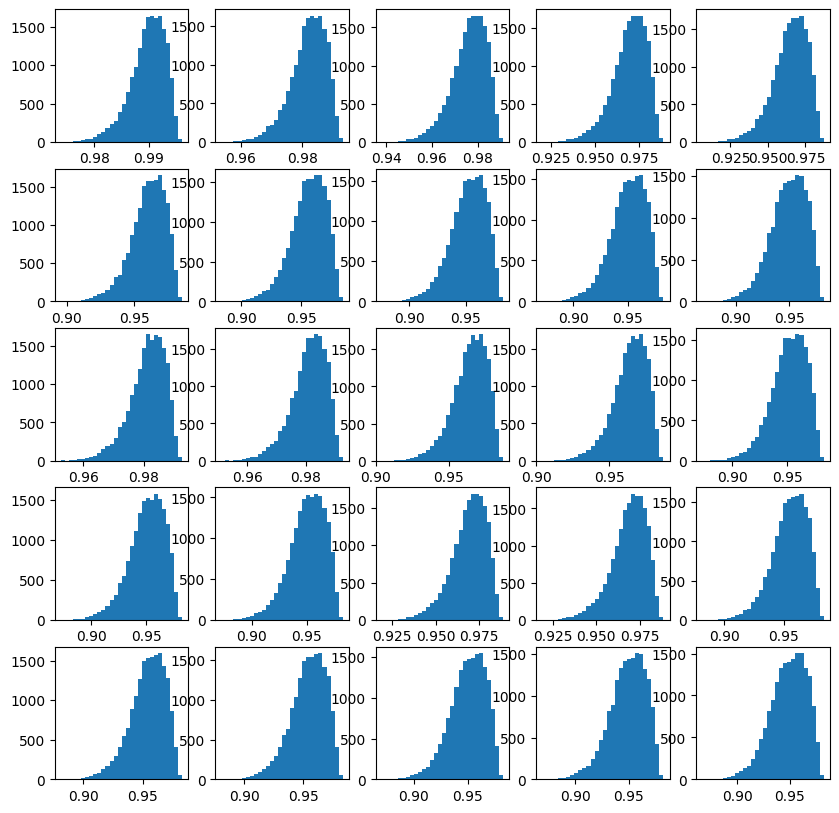

In [11]:
plt.figure(figsize=(10,10))
for i in range(1,len(net.bus)):
    plt.subplot(5,5,i)
    plt.hist(all_v2_pp[i],bins=30)
plt.show()

### Active Power

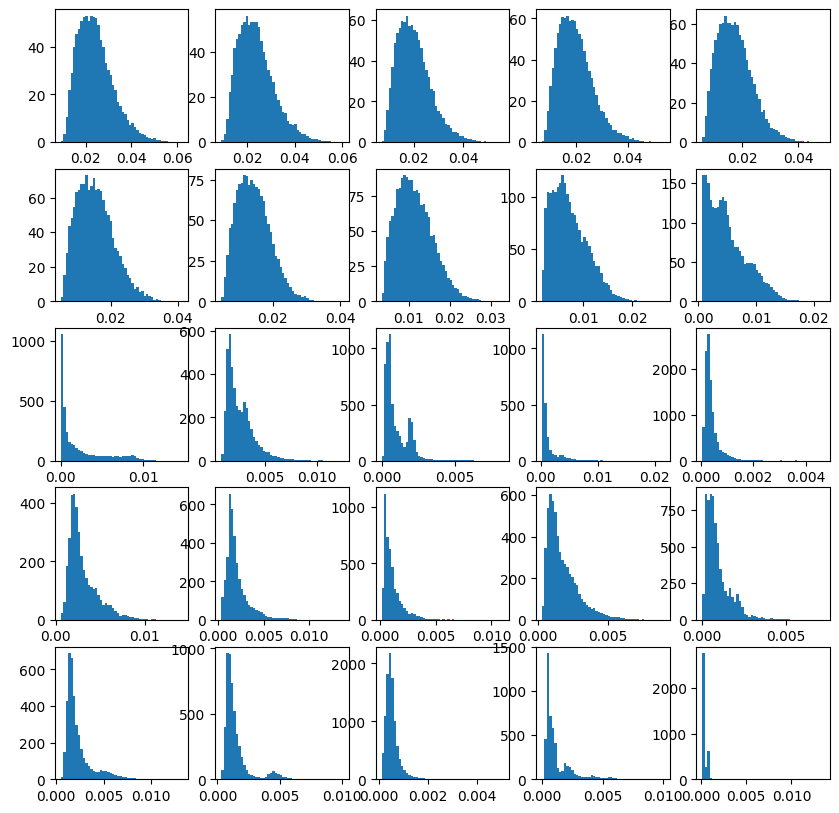

In [12]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(all_p_pp[(i,j)], bins=50, density=True)
    k+=1
plt.show()

### Reactive Power

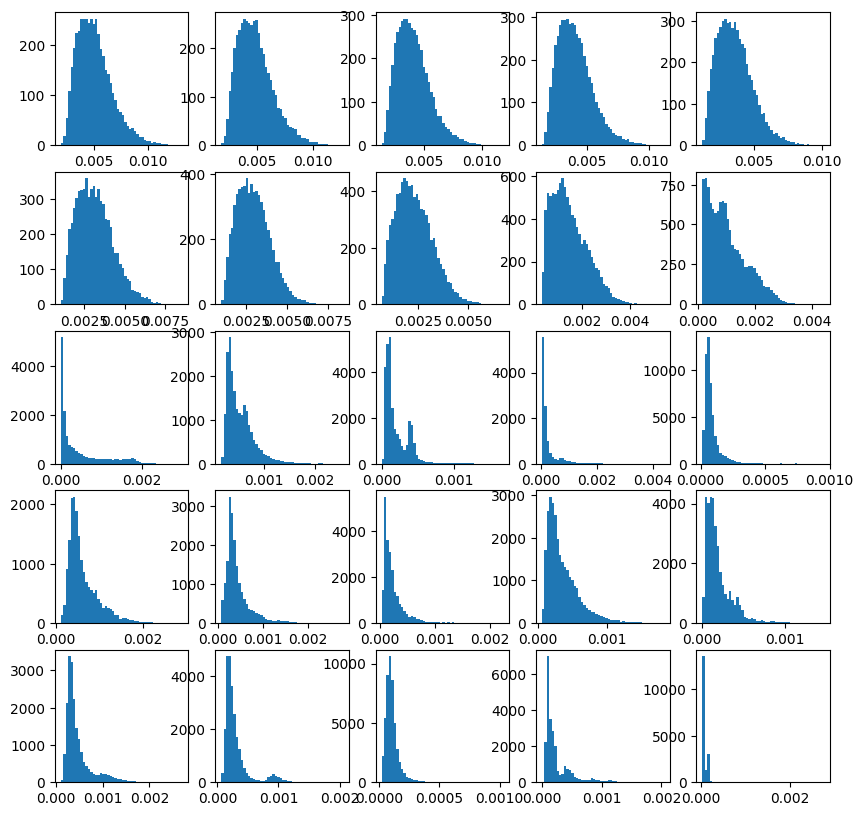

In [13]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(all_q_pp[(i,j)], bins=50, density=True)
    k+=1
plt.show()

### Current

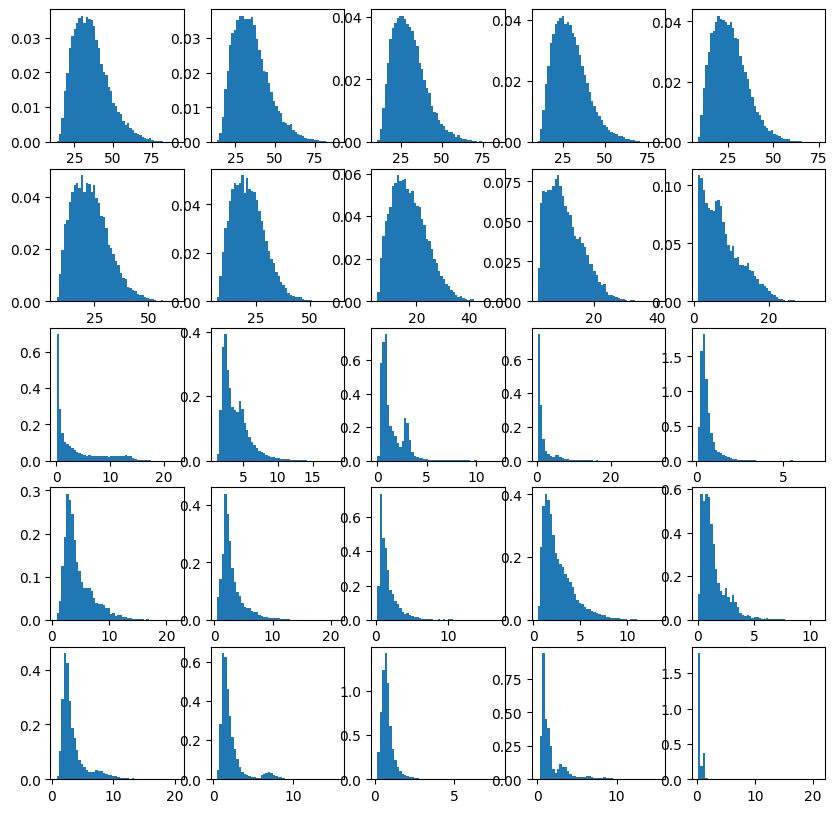

In [14]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(np.array(all_i_pp[(i,j)])*1e3, bins=50, density=True)
    k+=1
plt.show()

## Get Pecan Street Data

In [15]:
all_lognormals_p = pickle.load(open(os.path.join(dir_file,"all_lognormals_p.pkl"), "rb"))
all_lognormals_q = pickle.load(open(os.path.join(dir_file, "all_lognormals_q.pkl"), "rb"))
users = list(all_lognormals_p.keys())
n_users = len(users)

P_load_lognormal = [None]*len(net.bus)
Q_load_lognormal = [None]*len(net.bus)
for i,j in enumerate(users):
    P_load_lognormal[i+1] = lognormal_RV(all_lognormals_p[j].mu, all_lognormals_p[j].sigma, 0.0)
    Q_load_lognormal[i+1] = lognormal_RV(all_lognormals_q[j].mu, all_lognormals_q[j].sigma, 0.0)

s_base = 1e3
v_base = 400
z_base = (v_base**2)/(s_base)
i_base = s_base/(v_base*np.sqrt(3))
branches = get_branches(net, z_base)
ordered_nodes, ordered_branches = order_branch(branches,0)

In [16]:
t0 = time.time()
out_dist = distflow_lognormal_iterative(branches, P_load_lognormal, Q_load_lognormal, 0, slack_value=1.0, order_branch_bool=False, nodes=ordered_nodes, initial_sol = None)
t1 = time.time()
total = t1-t0
print(f"\nTotal time: {total}")

 current iteration : 4 of 100
Total time: 5.333574056625366


## Plot Results

### Current

error for the active power from 0 to 1 is 2.49%
error for the active power from 1 to 2 is 2.50%
error for the active power from 2 to 3 is 3.64%
error for the active power from 3 to 4 is 3.94%
error for the active power from 4 to 5 is 5.59%
error for the active power from 5 to 6 is 6.88%
error for the active power from 6 to 7 is 8.95%
error for the active power from 7 to 8 is 11.31%
error for the active power from 8 to 9 is 14.36%
error for the active power from 9 to 10 is 13.34%
error for the active power from 10 to 25 is 8.56%
error for the active power from 2 to 11 is 7.63%
error for the active power from 11 to 12 is 8.11%
error for the active power from 5 to 13 is 12.96%
error for the active power from 13 to 14 is 5.53%
error for the active power from 8 to 15 is 6.99%
error for the active power from 15 to 16 is 6.24%
error for the active power from 16 to 17 is 4.91%
error for the active power from 4 to 18 is 5.35%
error for the active power from 18 to 19 is 2.39%
error for the activ

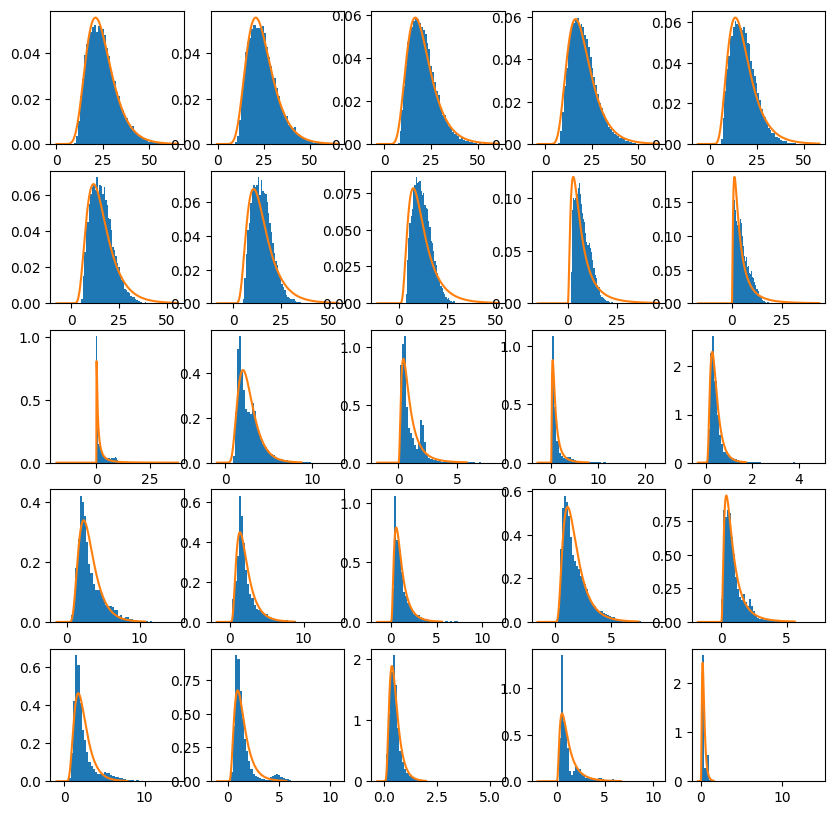

In [17]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(np.array(all_i_pp[(i,j)])*1e3/i_base, bins=50, density=True)
    x = np.linspace(out_dist["I"][(i,j)].get_mean()-3*out_dist["I"][(i,j)].get_std(),out_dist["I"][(i,j)].get_mean()+5*out_dist["I"][(i,j)].get_std(),1000)
    plt.plot(x,out_dist["I"][(i,j)].pdf(x))
    k+=1
    error_val = out_dist["I"][(i,j)].evaluate_approx(np.array(all_i_pp[(i,j)])*1e3/i_base)[0]
    print(f"error for the active power from {i} to {j} is {error_val*100:.2f}%")
plt.show()

### Voltage

KstestResult(statistic=np.float64(0.025446005310399644), pvalue=np.float64(2.2799983931353077e-10), statistic_location=np.float64(0.990121104877454), statistic_sign=np.int8(1))
error for the voltage magnitude of bus 1 is 2.54%
KstestResult(statistic=np.float64(0.025400878985427144), pvalue=np.float64(2.4726448853052365e-10), statistic_location=np.float64(0.9823399645850234), statistic_sign=np.int8(1))
error for the voltage magnitude of bus 2 is 2.54%
KstestResult(statistic=np.float64(0.029470172655524207), pvalue=np.float64(9.226644593803651e-14), statistic_location=np.float64(0.9777331426806761), statistic_sign=np.int8(1))
error for the voltage magnitude of bus 3 is 2.95%
KstestResult(statistic=np.float64(0.03232627652287623), pvalue=np.float64(1.7994772472521178e-16), statistic_location=np.float64(0.9715000556578179), statistic_sign=np.int8(1))
error for the voltage magnitude of bus 4 is 3.23%
KstestResult(statistic=np.float64(0.03727564282505247), pvalue=np.float64(9.237639023182972

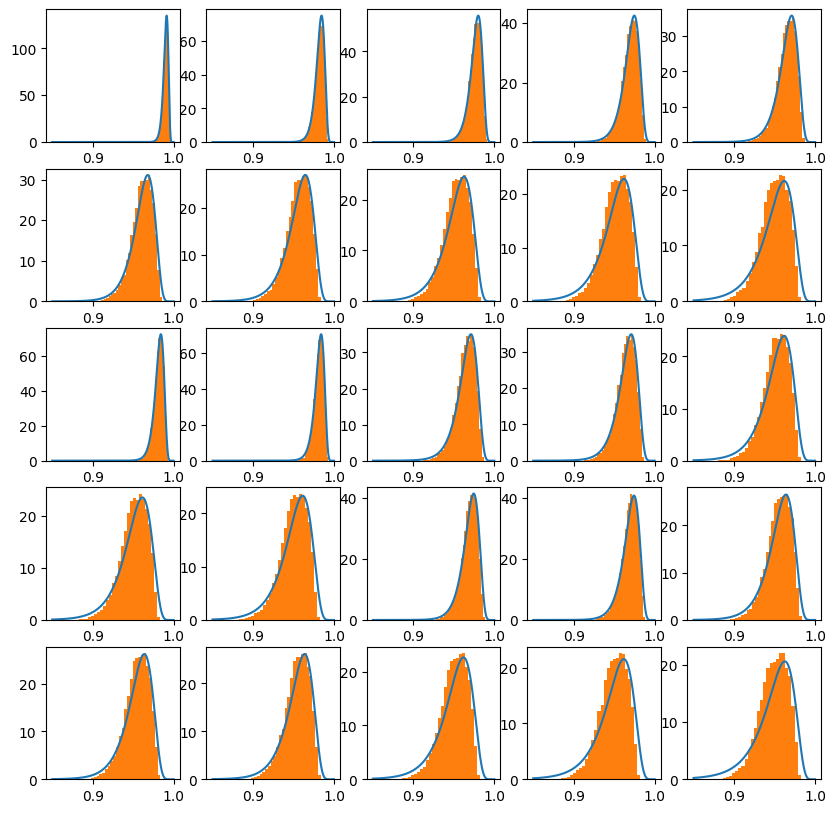

In [18]:
plt.figure(figsize=(10,10))
x = np.linspace(0.85,1,1500)
for i in range(1,len(net.bus)):
    plt.subplot(5,5,i)
    plt.plot(x, out_dist['V_mag'][i].pdf(x))
    plt.hist(all_v2_pp[i],bins=30, density=True)
    error_val = out_dist['V_mag'][i].evaluate_approx(all_v2_pp[i])[0]
    print(out_dist['V_mag'][i].evaluate_approx(all_v2_pp[i]))
    print(f"error for the voltage magnitude of bus {i} is {error_val*100:.2f}%")
plt.show()

### Active Power

error for the active power from 0 to 1 is 2.52%
error for the active power from 1 to 2 is 2.55%
error for the active power from 2 to 3 is 3.79%
error for the active power from 3 to 4 is 4.13%
error for the active power from 4 to 5 is 5.73%
error for the active power from 5 to 6 is 7.15%
error for the active power from 6 to 7 is 9.35%
error for the active power from 7 to 8 is 11.66%
error for the active power from 8 to 9 is 14.60%
error for the active power from 9 to 10 is 13.42%
error for the active power from 10 to 25 is 8.57%
error for the active power from 2 to 11 is 7.59%
error for the active power from 11 to 12 is 8.13%
error for the active power from 5 to 13 is 13.06%
error for the active power from 13 to 14 is 5.65%
error for the active power from 8 to 15 is 6.95%
error for the active power from 15 to 16 is 6.29%
error for the active power from 16 to 17 is 4.77%
error for the active power from 4 to 18 is 5.34%
error for the active power from 18 to 19 is 2.37%
error for the activ

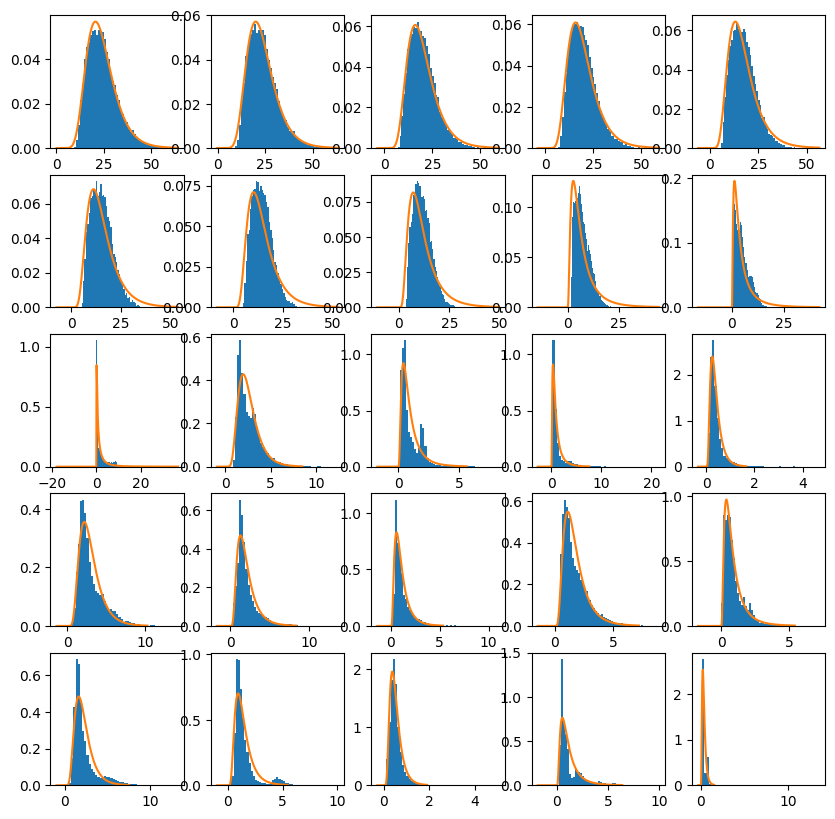

In [19]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(np.array(all_p_pp[(i,j)])*1e3, bins=50, density=True)
    x = np.linspace(out_dist["P"][(i,j)].get_mean()-3*out_dist["P"][(i,j)].get_std(),out_dist["P"][(i,j)].get_mean()+5*out_dist["P"][(i,j)].get_std(),1000)
    plt.plot(x,out_dist["P"][(i,j)].pdf(x))
    k+=1
    error_val = out_dist["P"][(i,j)].evaluate_approx(np.array(all_p_pp[(i,j)])*1e3)[0]
    print(f"error for the active power from {i} to {j} is {error_val*100:.2f}%")
plt.show()

### Reactive Power

error for the reactive power from 0 to 1 is 2.14%
error for the reactive power from 1 to 2 is 2.03%
error for the reactive power from 2 to 3 is 3.10%
error for the reactive power from 3 to 4 is 3.53%
error for the reactive power from 4 to 5 is 5.29%
error for the reactive power from 5 to 6 is 6.74%
error for the reactive power from 6 to 7 is 9.00%
error for the reactive power from 7 to 8 is 11.46%
error for the reactive power from 8 to 9 is 14.49%
error for the reactive power from 9 to 10 is 13.37%
error for the reactive power from 10 to 25 is 8.54%
error for the reactive power from 2 to 11 is 7.61%
error for the reactive power from 11 to 12 is 8.13%
error for the reactive power from 5 to 13 is 13.04%
error for the reactive power from 13 to 14 is 5.66%
error for the reactive power from 8 to 15 is 6.99%
error for the reactive power from 15 to 16 is 6.31%
error for the reactive power from 16 to 17 is 4.78%
error for the reactive power from 4 to 18 is 5.36%
error for the reactive power fr

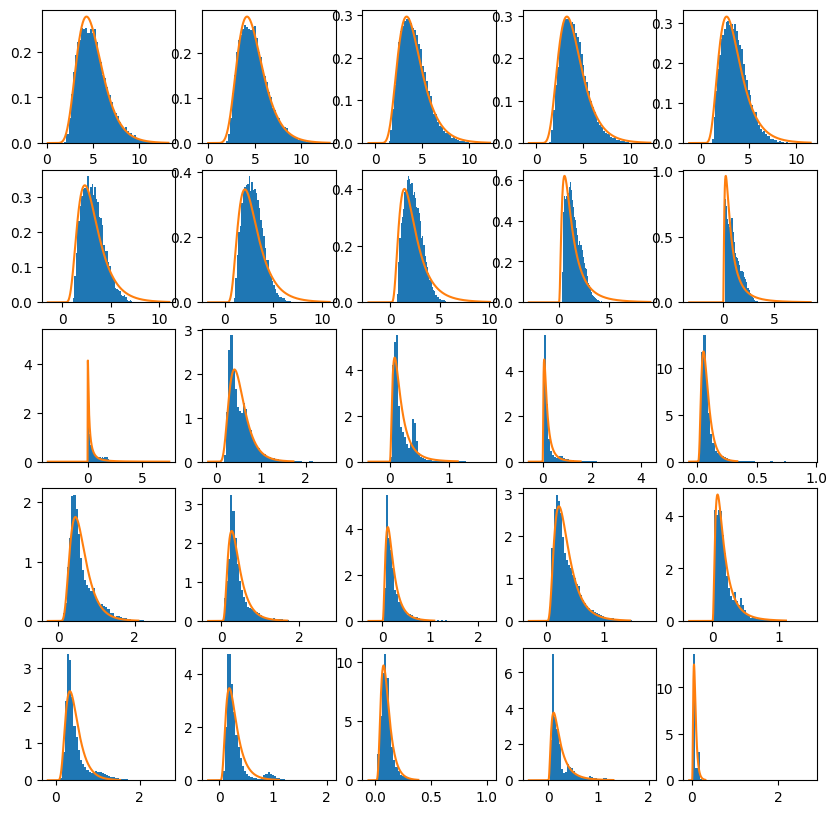

In [20]:
plt.figure(figsize=(10,10))
k=1
for i,j,_,_ in branches:
    plt.subplot(5,5,k)
    plt.hist(np.array(all_q_pp[(i,j)])*1e3, bins=50, density=True)
    x = np.linspace(out_dist["Q"][(i,j)].get_mean()-3*out_dist["Q"][(i,j)].get_std(),out_dist["Q"][(i,j)].get_mean()+5*out_dist["Q"][(i,j)].get_std(),1000)
    plt.plot(x,out_dist["Q"][(i,j)].pdf(x))
    k+=1
    error_val = out_dist["Q"][(i,j)].evaluate_approx(np.array(all_q_pp[(i,j)])*1e3)[0]
    print(f"error for the reactive power from {i} to {j} is {error_val*100:.2f}%")
plt.show()